In [32]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os
import copy 

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")

import pandas as pd
import numpy as np

In [33]:
## experiment info 

tissue = 'yeast'
target = 'wildVSrapa'
network_inf_method = 'INFERELATOR'
gsea_parent_folder_name = "INFERE_RAPA_e2e_48121620"
save_gsea_results_notes = ''

In [34]:
from node2vec2rank.dataloader import DataLoader

import json

#read the config file
config = json.load(open('../configs/config_infer_e2e.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

dataloader = DataLoader(config)

There are 129 row nodes and 2445 column nodes in graph 1
There are 129 row nodes and 1523 column nodes in graph 2
Graphs are rectangular


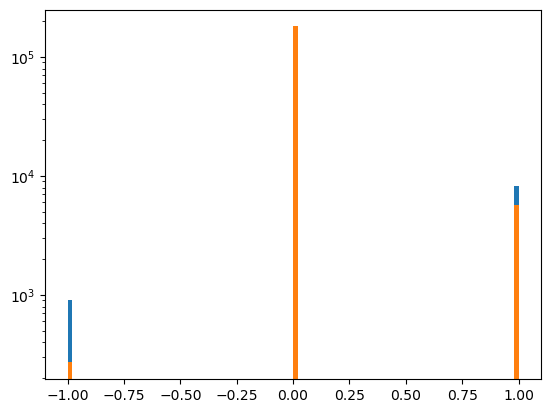

In [35]:
## plot the networks

import matplotlib.pyplot as plt

first = dataloader.graphs[0].to_numpy()
second = dataloader.graphs[1].to_numpy()
plt.hist(first.flatten(),log=True,bins=100);
plt.hist(second.flatten(),log=True,bins=100);

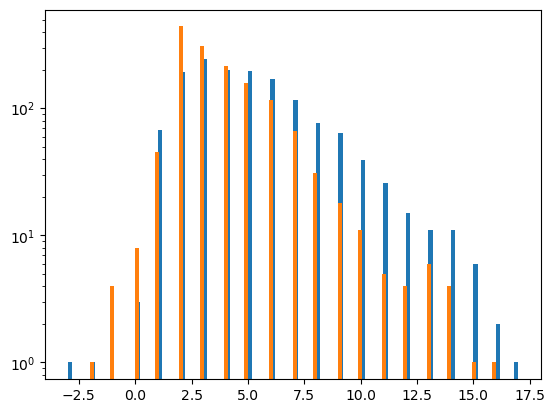

In [36]:
## plot their degrees

import matplotlib.pyplot as plt

plt.hist(np.sum(first,axis=0),log=True,bins=100);
plt.hist(np.sum(second,axis=0),log=True,bins=100);

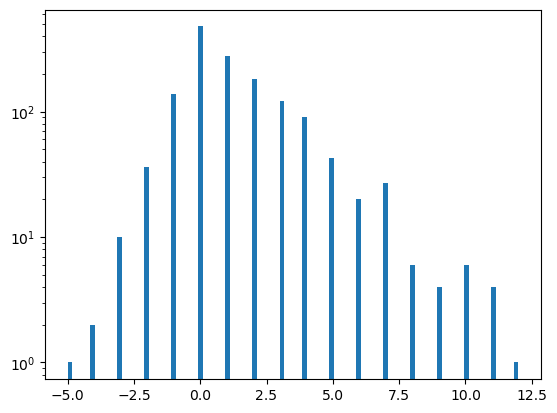

In [37]:
#plot the degree difference

plt.hist(np.sum(first,axis=0)-np.sum(second,axis=0),log=True,bins=100);

In [38]:
from node2vec2rank.preprocessing_utils import network_transform

first_trans = network_transform(first)
second_trans = network_transform(second)



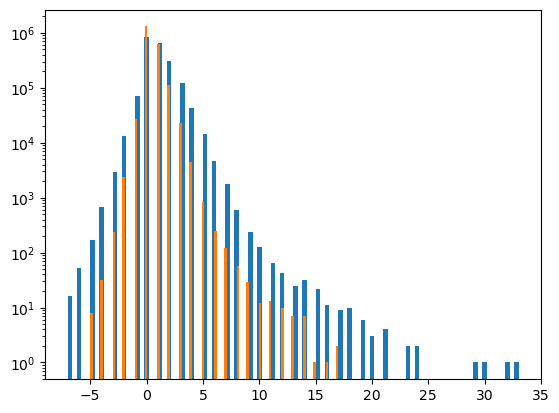

In [39]:
plt.hist(first_trans.flatten(),log=True,bins=100);
plt.hist(second_trans.flatten(),log=True,bins=100);

In [40]:
from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, node_names=dataloader.interest_nodes)

DeDi_ranking = model.degree_difference_ranking()

rankings = model.fit_transform_rank()

borda_rankings = model.aggregate_transform()

signed_rankings = model.signed_ranks_transform()

../output/08_21_2023_04_01_27

Running n2v2r with dimensions [4, 8, 12, 16, 20] and distance metrics ['euclidean', 'cosine'] ...
	UASE embedding in 1.21 seconds for bin=False and keep_top=100%
		Ranking in 0.79 seconds
n2v2r computed 10 rankings for 1 comparison(s) in 6.13 seconds

Rank aggregation with Borda ...
	Finished aggregation in 4.32 seconds

Signed ranks transformation ...
	Finished signed transformation in 0.65 seconds


In [41]:
comparison = '1vs2'
n2v2r_ranking_pd = rankings[comparison]
n2v2r_borda_ranking_pd = borda_rankings[comparison]
n2v2r_DeDi_ranking_pd = signed_rankings[comparison]
n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison]
DeDi_ranking_pd = DeDi_ranking[comparison]


# map orf to gene name
yeast_map_fn = '../data/gene_set_libraries/yeast/yeast_orf_to_symbol_mapping.tsv'
yeast_map = pd.read_csv(yeast_map_fn, sep="\t")
orf2symbol = {i['orf']:i['name'] for k,i in yeast_map.iterrows()}
genes_mapped = [orf2symbol[x] if x in orf2symbol else x for x in dataloader.interest_nodes ]

n2v2r_ranking_pd.index = genes_mapped
n2v2r_borda_ranking_pd.index = genes_mapped
n2v2r_DeDi_ranking_pd.index = genes_mapped
n2v2r_borda_DeDi_ranking_pd.index = genes_mapped
DeDi_ranking_pd.index = genes_mapped


In [42]:
# from node2vec2rank.visualization_utils import dim_reduction, plot_embeddings

# algorithm = 'pca'
# n_components = 3

# node_names = n2v2r_borda_ranking_pd.index.to_list()

# first_embeddings = model.node_embeddings[0]
# second_embeddings = model.node_embeddings[1]
# third_embeddings = model.node_embeddings[2]

# concat_embeddings = np.concatenate((first_embeddings, second_embeddings, third_embeddings), axis=0)

# first_embeddings_red = dim_reduction(
#     first_embeddings[:, :6], algorithm=algorithm, n_components=n_components)
# second_embeddings_red = dim_reduction(
#     second_embeddings[:, :6], algorithm=algorithm, n_components=n_components)
# third_embeddings = dim_reduction(
#     third_embeddings[:, :6], algorithm=algorithm, n_components=n_components)
# concat_embeddings_red = dim_reduction(
#     concat_embeddings[:, :6], algorithm=algorithm, n_components=n_components)

# plot_embeddings(first_embeddings_red, color_type='numeric',
#                 color=np.log(n2v2r_borda_ranking_pd.loc[node_names, 'borda_ranks']), names=node_names)
# plot_embeddings(second_embeddings_red, color_type='numeric',
#                 color=np.log(n2v2r_borda_ranking_pd.loc[node_names, 'borda_ranks']), names=node_names)


# num_nodes = first_embeddings_red.shape[0]
# color_one = np.zeros(num_nodes)
# color_two = np.ones(num_nodes)
# color_three = 2*np.ones(num_nodes)

# color_concat = np.concatenate((color_one, color_two, color_three), axis=0)

# plot_embeddings(concat_embeddings_red, color=color_concat,
#                 names=np.concatenate((node_names, node_names,node_names)))

In [43]:
# run enrich GSEA
from node2vec2rank.post_utils import enrichr_gseapy, read_gmt
from itertools import chain
import os

save_results = True


# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/yeast/KEGG_2018_yeast.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/yeast/GO_Biological_Process_2018_yeast.gmt'

# network_background or pathway_background for enrichment
# network will use the genes in the network only, while pathway will use all the genes in the pathways
# network is "more fair" but will find less things in small networks
background = 'network_background'
organism = 'yeast'

# take the top k percentage of the ranking for enrichment
top_k_percent = 10

if background == 'network_background':
    kegg_background = n2v2r_ranking_pd.index.to_list()
    gobp_background = n2v2r_ranking_pd.index.to_list()
elif background == 'pathway_background':
    kegg_dict = read_gmt(kegg_pathway_fn)
    kegg_background = list(set(chain.from_iterable(kegg_dict.values())))
    gobp_dict = read_gmt(gobp_pathway_fn)
    gobp_background = list(set(chain.from_iterable(gobp_dict.values())))
else:
    raise Exception("Enrichment background not properly set")

n2v2r_consensus_enr_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, background=kegg_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_consensus_enr_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, background=gobp_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_enr_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd.iloc[:,[0]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_enr_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd.iloc[:,[0]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_borda_enr_KEGG_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

n2v2r_borda_enr_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

absDeDi_enr_KEGG_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

absDeDi_enr_GOBP_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if save_results:
    path = '../results/results_gsea/' + gsea_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_consensus_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_consensus_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_borda_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                             "_n2v2r_borda_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_enr_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_enr_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_enr_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_enr_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')




In [44]:
from node2vec2rank.post_utils import plot_gseapy_enrich 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_parent_folder_name
# save_directory = None


title = network_inf_method+ " " +  tissue +  " KEGG ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

plot_gseapy_enrich(n2v2r_consensus_enr_KEGG_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
plot_gseapy_enrich(n2v2r_enr_KEGG_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r " + title,output_dir=save_directory)
plot_gseapy_enrich(n2v2r_borda_enr_KEGG_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
plot_gseapy_enrich(absDeDi_enr_KEGG_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)

title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

plot_gseapy_enrich(n2v2r_consensus_enr_GOBP_pd, has_stability=True, padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
plot_gseapy_enrich(n2v2r_enr_GOBP_pd, padj_cutoff=padj_cutoff,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r " + title,output_dir=save_directory)
plot_gseapy_enrich(n2v2r_borda_enr_GOBP_pd, padj_cutoff=padj_cutoff,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
plot_gseapy_enrich(absDeDi_enr_GOBP_pd, padj_cutoff=padj_cutoff, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)



No results found for n2v2r INFERELATOR yeast KEGG ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2
No results found for n2v2r borda INFERELATOR yeast KEGG ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2


No results found for n2v2r cons. INFERELATOR yeast GOBP ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2
No results found for n2v2r INFERELATOR yeast GOBP ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2
No results found for n2v2r borda INFERELATOR yeast GOBP ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2
No results found for absDeDi INFERELATOR yeast GOBP ORA wildVSrapa padj 0.1 network_background top 10 stab 0.2


In [45]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True

# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/yeast/KEGG_2018_yeast.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/yeast/GO_Biological_Process_2018_yeast.gmt'

prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1000

n2v2r_consensus_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_consensus_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd, gobp_pathway_fn,prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd.iloc[:,[0]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd.iloc[:,[0]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

absDeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

absDeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

DeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[0]], kegg_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

DeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[0]], gobp_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_DeDi_pre_KEGG_pd = prerank_gseapy(n2v2r_DeDi_ranking_pd.iloc[:,[0]], kegg_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                            prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_DeDi_pre_GOBP_pd = prerank_gseapy(n2v2r_DeDi_ranking_pd.iloc[:,[0]], gobp_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                            prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_DeDi_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_DeDi_ranking_pd, kegg_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                            prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_borda_DeDi_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_DeDi_ranking_pd, gobp_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                            prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_consensus_DeDi_pre_KEGG_pd = prerank_gseapy(n2v2r_DeDi_ranking_pd, kegg_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                      prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

n2v2r_consensus_DeDi_pre_GOBP_pd = prerank_gseapy(n2v2r_DeDi_ranking_pd, gobp_pathway_fn, one_sided=False, prerank_weight=prerank_weight,
                                      prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_consensus_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_consensus_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    DeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_DeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    DeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_DeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_DeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r_DeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_DeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r_DeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    n2v2r_borda_DeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r_borda_DeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_borda_DeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r_borda_DeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    n2v2r_consensus_DeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                  "_n2v2r_consensus_DeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    n2v2r_consensus_DeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                  "_n2v2r_consensus_DeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

2023-08-21 04:01:45,615 [WARNING] Duplicated values found in preranked stats: 5.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-21 04:01:46,656 [WARNING] Duplicated values found in preranked stats: 4.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-21 04:01:47,737 [WARNING] Duplicated values found in preranked stats: 5.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-21 04:01:48,989 [WARNING] Duplicated values found in preranked stats: 4.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-21 04:01:50,254 [WARNING] Duplicated values found in preranked stats: 5.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-08-21 04:01:51,610 [WARNING] Duplicated values found in preranked stats: 4.91% of genes
The order of those genes will be

In [46]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_parent_folder_name
# save_directory = None


title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)


plot_gseapy_prerank(n2v2r_consensus_pre_KEGG_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r consensus " +title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_consensus_DeDi_pre_KEGG_pd,has_stability=True, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r+DeDi consensus " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_pre_KEGG_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_DeDi_pre_KEGG_pd,has_stability=False, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r+DeDi " + title, output_dir=save_directory)

plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_borda_DeDi_pre_KEGG_pd,has_stability=False, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r_borda+DeDi " + title, output_dir=save_directory)

plot_gseapy_prerank(absDeDi_pre_KEGG_pd,has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " + title, output_dir=save_directory)
plot_gseapy_prerank(DeDi_pre_KEGG_pd,has_stability=False, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="DeDi " + title, output_dir=save_directory)

title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)

plot_gseapy_prerank(n2v2r_consensus_pre_GOBP_pd, has_stability=True, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r consensus " +title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_consensus_DeDi_pre_GOBP_pd,has_stability=True,one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r+DeDi consensus " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_pre_GOBP_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_DeDi_pre_GOBP_pd,has_stability=False, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r+DeDi " + title, output_dir=save_directory)

plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " + title, output_dir=save_directory)
plot_gseapy_prerank(n2v2r_borda_DeDi_pre_GOBP_pd,has_stability=False, one_sided= False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r_borda+DeDi " + title, output_dir=save_directory)

plot_gseapy_prerank(absDeDi_pre_GOBP_pd,has_stability=False,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " + title, output_dir=save_directory)
plot_gseapy_prerank(DeDi_pre_GOBP_pd,has_stability=False,padj_cutoff=padj_cutoff, one_sided= False, stability_cutoff=stability_cutoff, title="DeDi " + title, output_dir=save_directory)


No results found for absDeDi INFERELATOR yeast KEGG prerank wildVSrapa padj 0.1 stab 0.2


No results found for n2v2r borda INFERELATOR yeast GOBP prerank wildVSrapa padj 0.1 stab 0.2
